<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Scenario-1:-TSE-on-discrete-grids" data-toc-modified-id="Scenario-1:-TSE-on-discrete-grids-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Scenario 1: TSE on discrete grids</a></span><ul class="toc-item"><li><span><a href="#Evaluation-metrics" data-toc-modified-id="Evaluation-metrics-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Evaluation metrics</a></span></li><li><span><a href="#Load-the-dataset" data-toc-modified-id="Load-the-dataset-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Load the dataset</a></span></li><li><span><a href="#Define-the-model" data-toc-modified-id="Define-the-model-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Define the model</a></span><ul class="toc-item"><li><span><a href="#Component-1:-Random-Fourier-Features" data-toc-modified-id="Component-1:-Random-Fourier-Features-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Component 1: Random Fourier Features</a></span></li><li><span><a href="#Component-2:-Coordinate-based-MLPs" data-toc-modified-id="Component-2:-Coordinate-based-MLPs-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Component 2: Coordinate-based MLPs</a></span></li><li><span><a href="#Component-3:-Factorized-Implicit-Neural-Representations" data-toc-modified-id="Component-3:-Factorized-Implicit-Neural-Representations-1.3.3"><span class="toc-item-num">1.3.3&nbsp;&nbsp;</span>Component 3: Factorized Implicit Neural Representations</a></span></li></ul></li><li><span><a href="#Model-training" data-toc-modified-id="Model-training-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Model training</a></span><ul class="toc-item"><li><span><a href="#settings" data-toc-modified-id="settings-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>settings</a></span></li><li><span><a href="#run-the-training-and-inference" data-toc-modified-id="run-the-training-and-inference-1.4.2"><span class="toc-item-num">1.4.2&nbsp;&nbsp;</span>run the training and inference</a></span></li><li><span><a href="#plot-the-results" data-toc-modified-id="plot-the-results-1.4.3"><span class="toc-item-num">1.4.3&nbsp;&nbsp;</span>plot the results</a></span></li></ul></li></ul></li><li><span><a href="#Scenario-2:-TSE-on-continuous-trajectory-points" data-toc-modified-id="Scenario-2:-TSE-on-continuous-trajectory-points-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Scenario 2: TSE on continuous trajectory points</a></span><ul class="toc-item"><li><span><a href="#Define-the-adapted-version-of-ST-INR" data-toc-modified-id="Define-the-adapted-version-of-ST-INR-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Define the adapted version of ST-INR</a></span></li><li><span><a href="#Load-the-trajectory-data" data-toc-modified-id="Load-the-trajectory-data-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Load the trajectory data</a></span></li><li><span><a href="#settings" data-toc-modified-id="settings-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>settings</a></span><ul class="toc-item"><li><span><a href="#model-training" data-toc-modified-id="model-training-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>model training</a></span></li><li><span><a href="#training-performances" data-toc-modified-id="training-performances-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>training performances</a></span></li><li><span><a href="#make-predictions-on-all-the-trajectory-points" data-toc-modified-id="make-predictions-on-all-the-trajectory-points-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>make predictions on all the trajectory points</a></span></li><li><span><a href="#Superresolution-prediction" data-toc-modified-id="Superresolution-prediction-2.3.4"><span class="toc-item-num">2.3.4&nbsp;&nbsp;</span>Superresolution prediction</a></span></li></ul></li></ul></li></ul></div>

**In this notebook, we will develop a ST-INR model from scratch in the traffic speed field reconstruction task.**  We consider two kinds of scenarios:

- Discrete girds: in this case, the speed data is organized as a matrix and each cell contains the aggregated speed value;
- Continuous trajectory points: instead, as ST-INR is a continuous model, it can be applied to the raw trajectory point.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

from torch import nn, optim 
import numpy as np 
import scipy.io
from typing import Optional,List
import torch
import math
from torch import Tensor
import torch.nn.functional as F

dtype = torch.cuda.FloatTensor

## Scenario 1: TSE on discrete grids

### Evaluation metrics

In [2]:
def compute_mape(var, var_hat):
    return np.sum(np.abs(var - var_hat) / var) / var.shape[0]

def compute_wmape(var, var_hat):
    return np.sum(np.abs(var - var_hat)) / np.sum(var)

def compute_rmse(var, var_hat):
    return np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])

def compute_mae(var, var_hat):
    return np.sum(np.abs((var - var_hat))) / var.shape[0]

### Load the dataset

(215, 520)


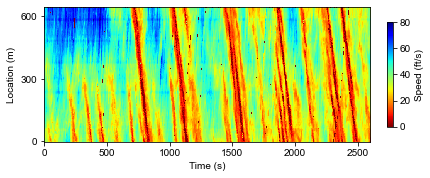

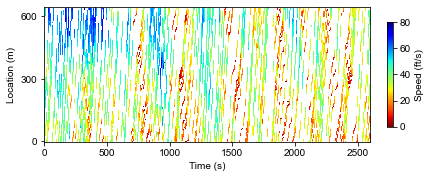

In [3]:
path = 'datasets/NGSIM/'

def plot_speed_field(data):
    fig = plt.figure(figsize = (2.5 * 2.5, 2.5))
    plt.matshow(data, cmap='jet_r', origin='lower', 
                vmin = 0, vmax = 80, fignum = 1)
    plt.gca().xaxis.set_ticks_position('bottom')
    plt.xticks([0, 100, 200, 300, 400, 500], [0, 500, 1000, 1500, 2000, 2500])
    plt.yticks([0, 100, 200], [0, 300, 600])
    plt.xlabel('Time (s)')
    plt.ylabel('Location (m)')
    cbar = plt.colorbar(fraction = 0.015)
    cbar.ax.set_ylabel('Speed (ft/s)')
    plt.show()
    
dense_mat = np.load(path+'ngsim_dense.npy')
sparse_mat = np.load(path+'ngsim_sparse_15.npy')
print(dense_mat.shape)
plot_speed_field(dense_mat)
plot_speed_field(sparse_mat)

### Define the model

#### Component 1: Random Fourier Features

In [4]:
class GaussianFourierFeatureTransform(nn.Module):
    """
    Given an input of size [..., time, dim], returns a tensor of size [..., time,n_fourier_feats].
    """
    def __init__(self, input_dim: int, n_fourier_feats: int, scales: List[int]):
        super().__init__()
        self.input_dim = input_dim
        self.n_fourier_feats = n_fourier_feats
        self.scales = scales

        n_scale_feats = n_fourier_feats // (2 * len(scales))
        assert n_scale_feats * 2 * len(scales) == n_fourier_feats, \
            f"n_fourier_feats: {n_fourier_feats} must be divisible by 2 * len(scales) = {2 * len(scales)}"
        B_size = (input_dim, n_scale_feats)
        B = torch.cat([torch.randn(B_size) * scale for scale in scales], dim=1)
        self.register_buffer('B', B)

    def forward(self, x: Tensor) -> Tensor:
        assert x.dim() >= 2, f"Expected 2 or more dimensional input (got {x.dim()}D input)"
        time, dim = x.shape[-2], x.shape[-1]

        assert dim == self.input_dim, \
            f"Expected input to have {self.input_dim} channels (got {dim} channels)"

        x = torch.einsum('... t n, n d -> ... t d', [x, self.B])
        x = 2 * math.pi * x
        return torch.cat([torch.sin(x), torch.cos(x)], dim=-1)

#### Component 2: Coordinate-based MLPs

In [5]:
class MixINR(nn.Module):
    def __init__(self, in_feats: int, layers: int, layer_size: int, out_size: int, n_fourier_feats: int, scales: float,
                 omega, dropout: Optional[float] = 0.1):
        super().__init__()
        self.features =  GaussianFourierFeatureTransform(in_feats, n_fourier_feats, scales)
        in_size = n_fourier_feats
        layers = [MLP(in_size, layer_size, dropout=dropout)] + \
                 [SineLayer(layer_size, layer_size, omega) for _ in range(layers - 1)] + \
                 [SineLayer(layer_size, out_size, omega)]
        self.layers = nn.Sequential(*layers)

    def forward(self, x: Tensor) -> Tensor:
        x = self.features(x)
        return self.layers(x)
    
class MLP(nn.Module):
    def __init__(self, input_size: int, output_size: int,
                 dropout: Optional[float] = 0.1):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.linear = nn.Linear(input_size, output_size)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(output_size)

    def forward(self, x: Tensor) -> Tensor:
        out = self._layer(x)
        return self.norm(out)

    def _layer(self, x: Tensor) -> Tensor:
        return self.dropout(torch.sin(self.linear(x))) 
    
    
class SineLayer(nn.Module):
    def __init__(self, in_features, out_features, omega_0, bias=True,
                 is_first=False): 
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

#### Component 3: Factorized Implicit Neural Representations

In [6]:
class ST_INR(nn.Module):
    def __init__(self, r_1,r_2,mid_channel,n_inr_layers,n_fourier_feats,scales, omega):
        super(ST_INR, self).__init__()
        
        self.U_net = MixINR(1,n_inr_layers, mid_channel,r_1, n_fourier_feats,scales, omega)
        self.V_net = MixINR(1,n_inr_layers, mid_channel,r_2, n_fourier_feats,scales, omega)
        
    def forward(self, centre, U_input, V_input):
        """
        centre: (r_1,r_2)
        """
        U = self.U_net(U_input) # [n1, 1]->[n1, r1]
        V = self.V_net(V_input) # [n2, 1]->[n2, r2]
        centre = centre.transpose(0,1) # (r_2,r_1)
        centre = centre @ U.t() # (r_2,n_1)
        centre = centre.transpose(0,1) # (n_1, r_2)
        centre = centre @ V.t() # (n_1, n_2)

        return centre

### Model training

#### settings

In [7]:
################### 
# hyperparameters. 
w_decay = 3  # related with the smoothness
lr = 0.0001
max_iter = 3000
omega = 0.3
n_fourier_feats = 2048 
scales = [0.01,0.02] 
n_inr_layers = 4
mid_channel = 1024 
###################

###################
# construct the input-output pair
X = torch.from_numpy(sparse_mat).type(dtype).cuda()
X = torch.where(torch.isnan(X), 0, X)
[n_1,n_2] = X.shape
r_1 = min(n_1,n_2)
r_2 = min(n_1,n_2) 
r_3 = min(n_1,n_2) 
gt = torch.from_numpy(dense_mat).type(dtype).cuda()
mask = torch.ones(X.shape).type(dtype)
mask[X == 0] = 0 
X[mask == 0] = 0
U_input = torch.from_numpy(np.array(range(1,n_1+1))).reshape(n_1,1).type(dtype)
V_input = torch.from_numpy(np.array(range(1,n_2+1))).reshape(n_2,1).type(dtype)
###################

#### run the training and inference

Note that this process can be viewed as a continuous version of matrix/tensor completion, optimized by gradient descend.

In [8]:
centre = torch.eye(r_1,r_1).type(dtype)  
stdv = 1 / math.sqrt(centre.size(0))
centre.data.uniform_(-stdv, stdv)
model = ST_INR(r_1,r_2,mid_channel,n_inr_layers,n_fourier_feats,scales,omega).type(dtype)
params = []
params += [x for x in model.parameters()]
centre.requires_grad=True
params += [centre]
optimizier = optim.Adam(params, lr=lr, weight_decay=w_decay) 

import time
start = time.time()

loss_record = []
for iter in range(max_iter):
    X_Out = model(centre, U_input, V_input)
    loss = torch.norm(X_Out*mask-X*mask,2)
    optimizier.zero_grad()
    loss.backward(retain_graph=True)
    optimizier.step()
    loss_record.append(loss.detach().cpu().numpy())
    
end = time.time()
print('Running time: %d seconds.'%(end - start))

Running time: 16 seconds.


#### plot the results

Text(0.5, 0, 'steps')

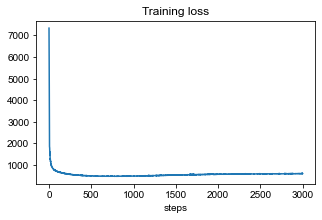

In [9]:
plt.subplots(figsize=(5,3))
plt.plot(loss_record)
plt.title('Training loss')
plt.xlabel('steps')

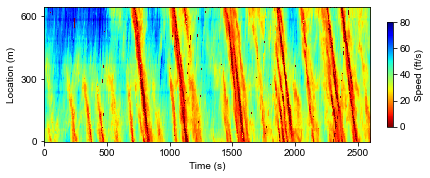

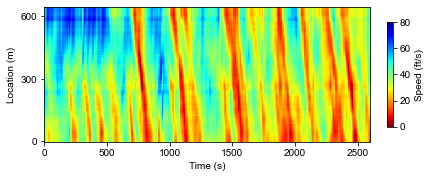

WAPE: 0.114605
RMSE: 5.05432
MAE:  3.8503


In [10]:
mat_hat = X_Out.cpu().detach().numpy()
plot_speed_field(gt.cpu().detach().numpy())
plot_speed_field(mat_hat)

if np.isnan(sparse_mat).any() == False:
    ind = sparse_mat != 0
    pos_test = np.where((dense_mat != 0) & (sparse_mat == 0))
elif np.isnan(sparse_mat).any() == True:
    ind = ~np.isnan(sparse_mat)
    pos_test = np.where((dense_mat > 0) & (np.isnan(sparse_mat)))
    sparse_mat[np.isnan(sparse_mat)] = 0
    
print('WAPE: {:.6}'.format(compute_wmape(dense_mat[pos_test], 
                                                    mat_hat[pos_test])))
print('RMSE: {:.6}'.format(compute_rmse(dense_mat[pos_test], 
                                        mat_hat[pos_test])))
print('MAE:  {:.6}'.format(compute_mae(dense_mat[pos_test], 
                                        mat_hat[pos_test])))

## Scenario 2: TSE on continuous trajectory points

### Define the adapted version of ST-INR

In [11]:
class ST_INR_C(nn.Module):
    def __init__(self, r_1,r_2,mid_channel,n_inr_layers,n_fourier_feats,scales, omega):
        super(ST_INR_C, self).__init__()
        
        self.U_net = MixINR(1,n_inr_layers, mid_channel,r_1, n_fourier_feats,scales, omega)
        self.V_net = MixINR(1,n_inr_layers, mid_channel,r_2, n_fourier_feats,scales, omega)

    def forward(self, centre, x, flag):
        """
        x: [n_samples, n_coords], can be a list when the input has different dimensions, or concated tensors
        centre: (r_1,r_2)
        flag: whether use sampled space or full space
        """
        U = self.U_net(x[0])  # [n, 1] -> [n, r1] 
        V = self.V_net(x[1])   # [n, 1] -> [n, r2] 
        if flag == 1:
            centre = centre.transpose(0,1) # [r2,r1]
            centre = centre @ U.t()  # [r2,r1] -> [r2,n]
            centre = centre.transpose(0,1) # [r2,n] -> [n,r2]
            centre = torch.matmul(centre.unsqueeze(1),V.unsqueeze(-1)) # [n,1,r2]*[n,r2,1] -> [n,1,1]
            centre = centre.squeeze(-1) #[n,1]
        elif flag == 2:
            centre = centre.transpose(0,1) # [r2,r1]
            centre = centre @ U.t()  # [r2,r1] -> [r2,n]
            centre = centre.transpose(0,1) # [n,r2]
            centre = centre @ V.t() # [n,r2]*[r2,n] -> [n,n]
        return centre

### Load the trajectory data

In [12]:
sparse_traj = pd.read_csv(path+'ngsim_sampled_trajectories_10.csv')
sparse_traj['Global_Time'] = sparse_traj['Global_Time']-sparse_traj['Global_Time'].min()
sparse_traj['Global_X'] = sparse_traj['Global_X']-sparse_traj['Global_X'].min()

In [13]:
dense_traj = pd.read_csv(path+'ngsim_sampled_trajectories_full.csv')
dense_traj['Global_Time'] = dense_traj['Global_Time']-dense_traj['Global_Time'].min()
dense_traj['Global_X'] = dense_traj['Global_X']-dense_traj['Global_X'].min()

Text(0, 0.5, 'Speed (ft/s)')

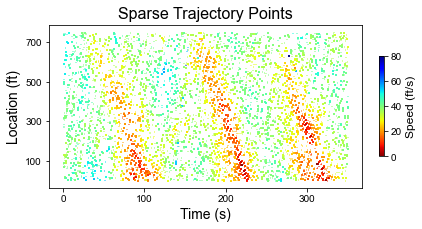

In [14]:
plt.figure(figsize=(6, 3))
plt.scatter(sparse_traj['Global_Time'],sparse_traj['Global_X'], s=0.5, marker='s',c=sparse_traj['v_Vel'],
            cmap='jet_r',vmin = 0, vmax = 80)
plt.xlabel('Time (s)',fontsize=14)
plt.ylabel('Location (ft)',fontsize=14)
plt.xticks([0, 100, 200, 300], [0, 100, 200, 300])
plt.yticks([100,300,500,700], [100,300,500, 700])
plt.title(f'Sparse Trajectory Points',fontsize=16)
plt.gca().xaxis.set_ticks_position('bottom') 
cbar = plt.colorbar(fraction = 0.015)
cbar.ax.set_ylabel('Speed (ft/s)',fontsize=12)

In [15]:
X_true = sparse_traj.v_Vel.values[...,None]
X_grid = sparse_traj[['Global_Time','Global_X']].values
X_true.shape, X_grid.shape

((5238, 1), (5238, 2))

### settings

In [16]:
################### 
# hyperparameters. 
w_decay = 3  
lr = 0.0001
max_iter = 2000
omega = 0.3
n_fourier_feats = 2048 
scales = [0.01,0.02] 
n_inr_layers = 2 #4
###################
mid_channel = 512 
r_1 = 256
r_2 = 256

#### model training

In [17]:
n = X_grid.shape[0]
U_input = torch.from_numpy(X_grid[:,0]).reshape(n,1).type(dtype)
U_input.requires_grad=True
V_input = torch.from_numpy(X_grid[:,1]).reshape(n,1).type(dtype)
V_input.requires_grad=True
X_input = [U_input, V_input]# [n, 2]

X = torch.from_numpy(X_true).type(dtype).cuda() # [n, 1]
centre = torch.eye(r_1,r_2).type(dtype)  
stdv = 1 / math.sqrt(centre.size(0))
centre.data.uniform_(-stdv, stdv)

model = ST_INR_C(r_1,r_2,mid_channel,n_inr_layers,n_fourier_feats,scales,omega).type(dtype)
params = []
params += [x for x in model.parameters()]
centre.requires_grad=True
params += [centre]
optimizier = optim.Adam(params, lr=lr, weight_decay=w_decay) 

import time
start = time.time()

loss_record = []
for it in range(max_iter):
    X_Out = model(centre, X_input, flag = 1)  # [n, 1]
    loss = torch.norm(X_Out-X,2)
    optimizier.zero_grad()
    loss.backward(retain_graph=True)
    optimizier.step()
    loss_record.append(loss.detach().cpu().numpy())
    
end = time.time()
print('Running time: %d seconds.'%(end - start))

Running time: 18 seconds.


Text(0.5, 0, 'steps')

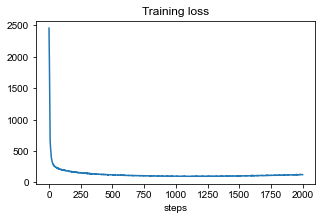

In [18]:
plt.subplots(figsize=(5,3))
plt.plot(loss_record)
plt.title('Training loss')
plt.xlabel('steps')

#### training performances

In [19]:
print('WAPE: {:.6}'.format(compute_wmape(X.detach().cpu().numpy(), X_Out.detach().cpu().numpy())))
print('RMSE: {:.6}'.format(compute_rmse(X.detach().cpu().numpy(), X_Out.detach().cpu().numpy())))
print('MAE:  {:.6}'.format(compute_mae(X.detach().cpu().numpy(), X_Out.detach().cpu().numpy())))

WAPE: 0.0387557
RMSE: 1.68683
MAE:  1.25601


#### make predictions on all the trajectory points

In [20]:
X_grid_full = dense_traj[['Global_Time','Global_X']].values
n = X_grid_full.shape[0]
U_input = torch.from_numpy(X_grid_full[:,0]).reshape(n,1).type(dtype)
U_input.requires_grad=True
V_input = torch.from_numpy(X_grid_full[:,1]).reshape(n,1).type(dtype)
V_input.requires_grad=True
X_input_full = [U_input, V_input]# [n, 2]
X_Out_full = model(centre, X_input_full, flag = 1)  # [n, 1]

X_true_full = dense_traj.v_Vel.values[...,None]
print('WAPE: {:.6}'.format(compute_wmape(X_true_full, X_Out_full.detach().cpu().numpy())))
print('RMSE: {:.6}'.format(compute_rmse(X_true_full, X_Out_full.detach().cpu().numpy())))
print('MAE:  {:.6}'.format(compute_mae(X_true_full, X_Out_full.detach().cpu().numpy())))

WAPE: 0.0629249
RMSE: 2.85312
MAE:  2.03575


#### Superresolution prediction

In [21]:
u_number = 1600
v_number = 800
add_border = 0.1
range_u = torch.from_numpy(np.array(range(u_number))).type(dtype)
range_v = torch.from_numpy(np.array(range(v_number))).type(dtype)
u = (torch.min(U_input)-add_border + (
    torch.max(U_input)-torch.min(U_input)+2*add_border) * (range_u/u_number)).reshape(u_number,1)
v = (torch.min(V_input)-add_border + (
    torch.max(V_input)-torch.min(V_input)+2*add_border) * (range_v/v_number)).reshape(v_number,1)

X_input_full = [u, v] # [n, 2]
X_Out_full = model(centre, X_input_full, flag = 2)  # [n1, n2]
X_Out_full.shape

torch.Size([1600, 800])

Text(0, 0.5, 'Speed (ft/s)')

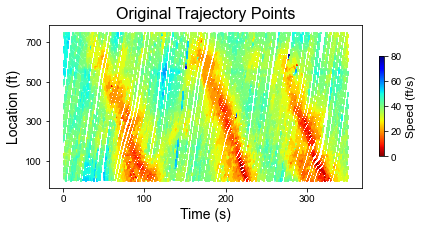

In [22]:
plt.figure(figsize=(6, 3))
plt.scatter(dense_traj['Global_Time'],dense_traj['Global_X'], s=0.5, marker='s',c=dense_traj['v_Vel'],
            cmap='jet_r',vmin = 0, vmax = 80)
plt.xlabel('Time (s)',fontsize=14)
plt.ylabel('Location (ft)',fontsize=14)
plt.xticks([0, 100, 200, 300], [0, 100, 200, 300])
plt.yticks([100,300,500,700], [100,300,500, 700])
plt.title(f'Original Trajectory Points',fontsize=16)
plt.gca().xaxis.set_ticks_position('bottom')  
cbar = plt.colorbar(fraction = 0.015)
cbar.ax.set_ylabel('Speed (ft/s)',fontsize=12)

Text(0, 0.5, 'Speed (ft/s)')

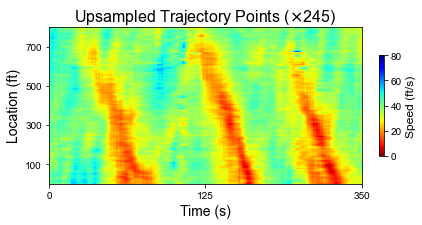

In [23]:
plt.figure(figsize=(6, 4))
mat_hat = X_Out_full.cpu().detach().numpy()
plt.matshow(mat_hat.T, cmap='jet_r', origin='lower', 
                vmin = 0, vmax = 80, fignum = 1)
plt.xlabel('Time (s)',fontsize=14)
plt.ylabel('Location (ft)',fontsize=14)
plt.xticks([0, 800, 1600], [0, 125, 350])
plt.yticks([100,300,500,700], [100,300,500,700])
plt.title(r'Upsampled Trajectory Points ($\times$245)',fontsize=16)
plt.gca().xaxis.set_ticks_position('bottom')  
cbar = plt.colorbar(fraction = 0.015)
cbar.ax.set_ylabel('Speed (ft/s)',fontsize=12)